In [1]:
import freud
import gsd.hoomd
import matplotlib.pyplot as plt
import hoomd
import copy
import numpy

In [2]:
del simulation

NameError: name 'simulation' is not defined

In [111]:
def rdf(snapshot, r_max, bin_width):
    positions = snapshot.particles.position
    box = snapshot.configuration.box
    Lx, Ly, Lz = box[0], box[1], box[2]
    N = len(positions)
    volume = Lx * Ly * Lz
    density = N / volume

    num_bins = int(r_max / bin_width)
    rdf_hist = numpy.zeros(num_bins)

    # Loop through all unique particle pairs
    for i in range(N):
        for j in range(i + 1, N):
            dr = positions[i] - positions[j]

            # Apply minimum image convention
            dr[0] -= Lx * numpy.round(dr[0] / Lx)
            dr[1] -= Ly * numpy.round(dr[1] / Ly)
            dr[2] -= Lz * numpy.round(dr[2] / Lz)

            r = numpy.linalg.norm(dr)
            if r < r_max:
                bin_index = int(r / bin_width)
                rdf_hist[bin_index] += 2  # (i,j) and (j,i)

    # Normalize RDF
    r = numpy.linspace(0.5 * bin_width, r_max - 0.5 * bin_width, num_bins)
    shell_volumes = (4/3) * numpy.pi * ((r + 0.5 * bin_width)**3 - (r - 0.5 * bin_width)**3)
    ideal_counts = density * shell_volumes * N
    g_r = rdf_hist / ideal_counts

    return r, g_r

In [112]:
def heat_cap(energies, T, N):
    E_mean = np.mean(np.array(energies))
    E2_mean = np.mean(np.array(energies)**2)
    Cv = (E2_mean - E_mean**2) / (T**2)
    Cv_per_particle = Cv / N
    return Cv_per_particle

In [113]:
def autocorr1D(array):
    ft = np.fft.rfft(array - np.average(array))
    acorr = np.fft.irfft(ft * np.conjugate(ft)) / (len(array) * np.var(array))
    dt = np.where(acorr < 1/np.e)[0][0]  # 1/e ≈ 0.37
    nsamples = len(array) // dt
    acorr = acorr[dt:nsamples]  # truncated, not used further
    return nsamples, dt

In [114]:
# Add this new function for computing relaxation time (ACF integral)
def relaxation_time_from_acf(array, dt_real):
    ft = np.fft.rfft(array - np.average(array))
    acf = np.fft.irfft(ft * np.conjugate(ft)) / (len(array) * np.var(array))
    acf = acf[:len(array)]  # keep all positive lags
    acf = acf[acf > 0]      # only positive region
    return np.sum(acf) * dt_real

In [115]:
potential_energy = {}
kinetic_energy = {}
total_energy = {}
snapshots = {}
heat_capacities = {}
dt = 0.005
epsilon = 1.0
sigma = 1.0
starting_density = 0.5
kTs = [0.5, 1.0, 1.5,2.0]
device = hoomd.device.CPU()
seed = numpy.random.randint(1,1e4)

for kT in kTs:
  print(kT)
  potential_energy[f"{kT}"] = []
  kinetic_energy[f"{kT}"] = []
  total_energy[f"{kT}"] = []
  snapshots[f"{kT}"] = []
  heat_capacities[f"{kT}"] = []
  simulation = hoomd.Simulation(device = device, seed = seed)

  #a is the spacing between particles
  a = 1/(starting_density**(1/3.0))
  #We want a number of particles N in our system.
  #Since we will be replicating the system in 3 dimensions, the number of unit cells we need is N^(1/3)
  num_replicas = 10
  N_particles = num_replicas**3
  grid_particles = freud.data.UnitCell([a,a,a,0,0,0],[[0,0,0]]).generate_system(num_replicas)
  box_length = grid_particles[0].Lx

  frame = gsd.hoomd.Frame()
  frame.particles.N = N_particles
  frame.particles.position = grid_particles[1]
  frame.configuration.box = [box_length,box_length,box_length,0,0,0]

  #Types of particles define different interactions. In an atomistic simulation these might be C, O, and H.
  #in a coarse-grained simulation we can give them a simple name like A
  frame.particles.typeid = [0]*N_particles
  frame.particles.types = ['A']

  #Finally, save our initial state:
  with gsd.hoomd.open(name='initial_state.gsd', mode='w') as f:
      f.append(frame)

  simulation.create_state_from_gsd(filename='initial_state.gsd')

  integrator = hoomd.md.Integrator(dt = dt)
  nvt = hoomd.md.methods.NVT(filter = hoomd.filter.All(), kT = kT , tau = dt*100)
  integrator.methods.append(nvt)

  cell = hoomd.md.nlist.Cell(buffer=0.4)

  #Define the force for different particles
  lj = hoomd.md.pair.LJ(nlist=cell)

  lj.params[('A', 'A')] = {"epsilon":epsilon, "sigma":sigma}

  lj.r_cut[('A', 'A')] = 2.5*sigma

  integrator.forces.append(lj)
  simulation.operations.integrator = integrator

  simulation.run(10)

  simulation.state.thermalize_particle_momenta(filter=hoomd.filter.All(), kT=kT)
  thermodynamic_properties = hoomd.md.compute.ThermodynamicQuantities(
      filter=hoomd.filter.All()
  )

  simulation.operations.computes.append(thermodynamic_properties)
  logger = hoomd.logging.Logger(categories=['scalar', 'sequence'])
  logger.add(thermodynamic_properties, quantities=['potential_energy', 'kinetic_energy'])
  tps_tracking = hoomd.logging.Logger(categories=['scalar', 'string'])
  tps_tracking.add(simulation, quantities=['timestep', 'tps'])
  table = hoomd.write.Table(trigger=hoomd.trigger.Periodic(period=int(1e3)), logger=tps_tracking)
  simulation.operations.writers.append(table)
  for step in range(10000):
      simulation.run(10)
      potential_energy[f"{kT}"].append(thermodynamic_properties.potential_energy)
      kinetic_energy[f"{kT}"].append(thermodynamic_properties.kinetic_energy)
      total_energy[f"{kT}"].append(thermodynamic_properties.kinetic_energy + thermodynamic_properties.potential_energy)
  snapshots[f"{kT}"] = simulation.state.get_snapshot()
  Cv_per_particle = heat_cap(total_energy[f"{kT}"], kT, N_particles)
  heat_capacities[f"{kT}"] = Cv_per_particle
  nsamples, dt_index = autocorr1D(total_energy[f"{kT}"])
  dt_real = dt * 10  # you're sampling energy every run(10)
    
  tau_relax = relaxation_time_from_acf(total_energy[f"{kT}"], dt_real)
    
  print(f"kT = {kT:.2f} | Decorrelation time ≈ {dt_index * dt_real:.3f} time units")
  print(f"kT = {kT:.2f} | Estimated independent samples: {nsamples}")
  print(f"kT = {kT:.2f} | Relaxation time ≈ {tau_relax:.3f} time units")

0.5
Simulation.timestep  Simulation.tps 
       1000            3435.11450   
       2000            3154.57413   
       3000            1756.44028   
       4000            1653.49991   
       5000            1724.46829   
       6000            1631.91296   
       7000            1629.84426   
       8000            1653.49991   
       9000            1712.00304   
       10000           1696.51272   
       11000           2944.06281   
       12000           1696.83258   
       13000           1482.45759   
       14000           1694.59612   
       15000           3007.01637   
       16000           1670.06866   
       17000           1581.72232   
       18000           1633.98693   
       19000           2460.36085   
       20000           1687.28909   
       21000           2752.29358   
       22000           2887.39172   
       23000           1585.34437   
       24000           2768.37896   
       25000           2423.26333   
       26000           1673.79580 

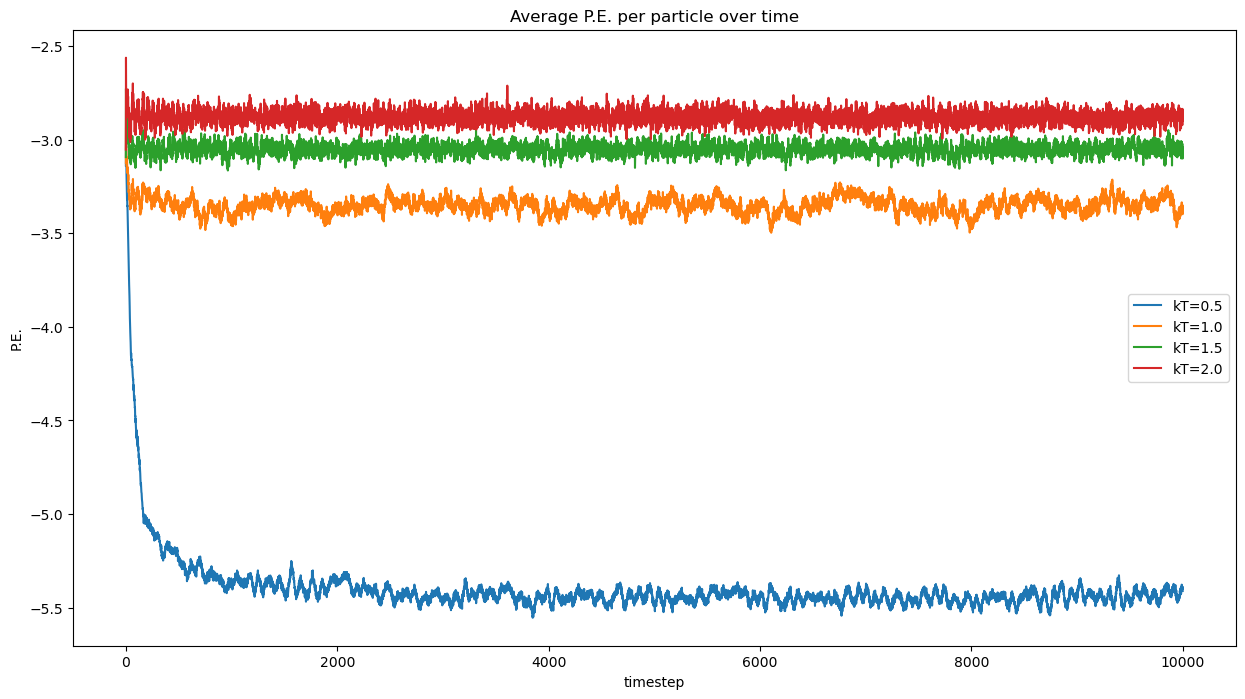

In [95]:
plt.figure(figsize = (15,8))
for kT, energies in potential_energy.items():
    plt.plot(numpy.array(energies[0:])/N_particles, label=f'kT={kT}')
plt.xlabel('timestep')
plt.ylabel('P.E.')
plt.title('Average P.E. per particle over time')
plt.legend()

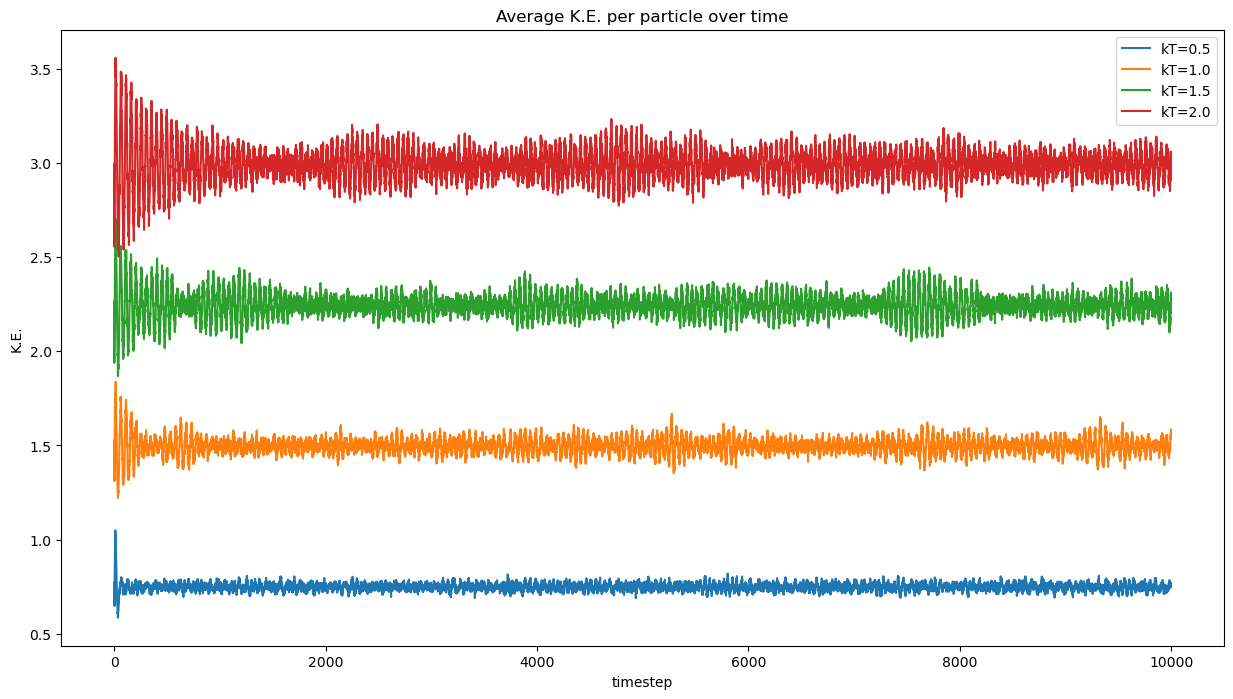

In [96]:
plt.figure(figsize = (15,8))
for kT, energies in kinetic_energy.items():
    plt.plot(numpy.array(energies[0:])/N_particles, label=f'kT={kT}')
plt.xlabel('timestep')
plt.ylabel('K.E.')
plt.title('Average K.E. per particle over time')
plt.legend()

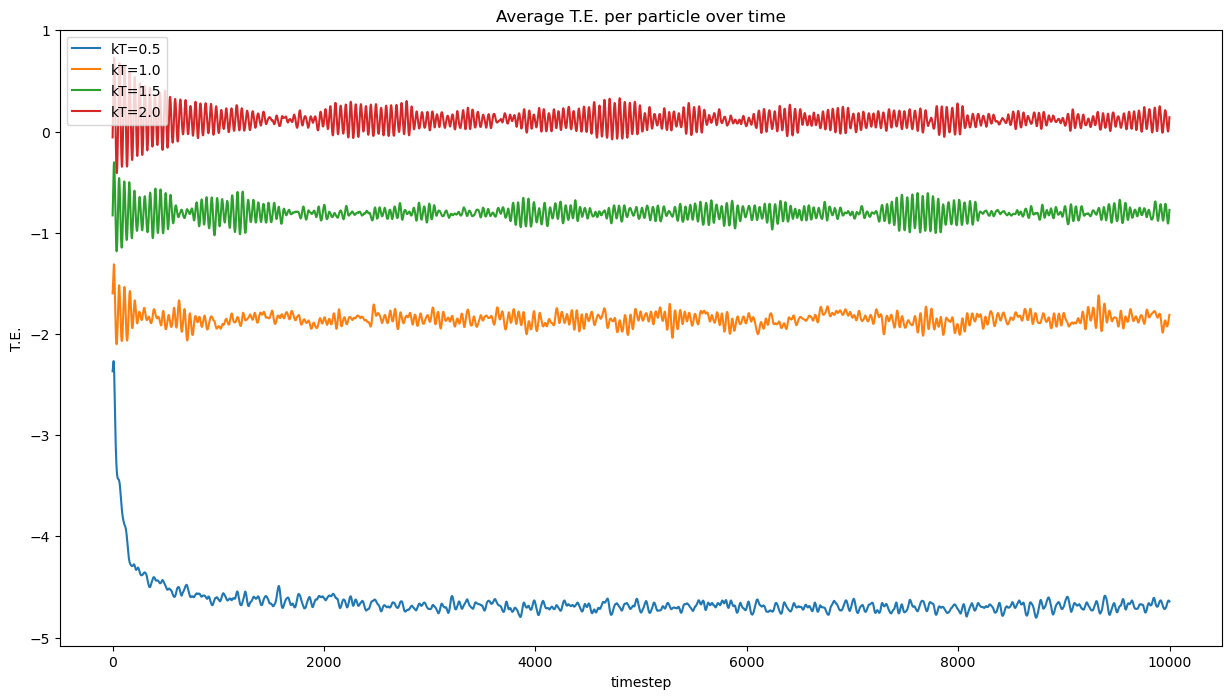

In [97]:
plt.figure(figsize = (15,8))
for kT, energies in total_energy.items():
    plt.plot(numpy.array(energies[0:])/N_particles, label=f'kT={kT}')
plt.xlabel('timestep')
plt.ylabel('T.E.')
plt.title('Average T.E. per particle over time')
plt.legend()

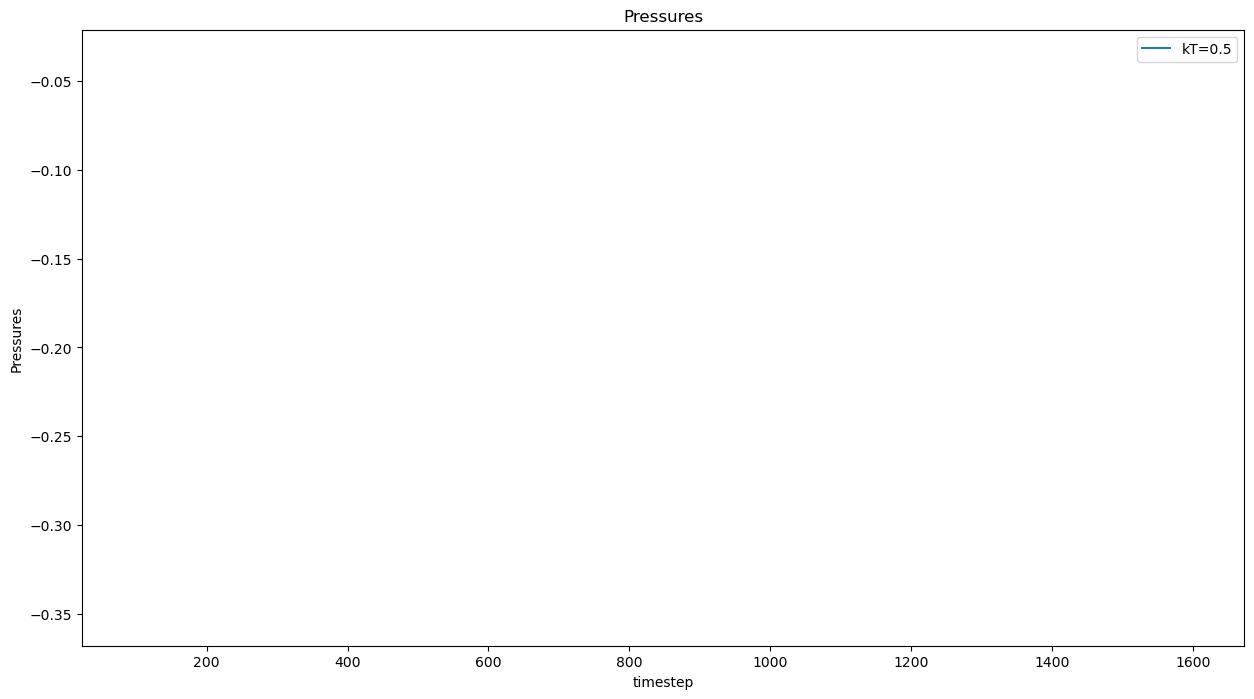

In [98]:
plt.figure(figsize = (15,8))
for kT, pressures in pressures.items():
    plt.plot(numpy.array(pressures[0:]), label=f'kT={kT}')
plt.xlabel('timestep')
plt.ylabel('Pressures')
plt.title('Pressures')
plt.legend()

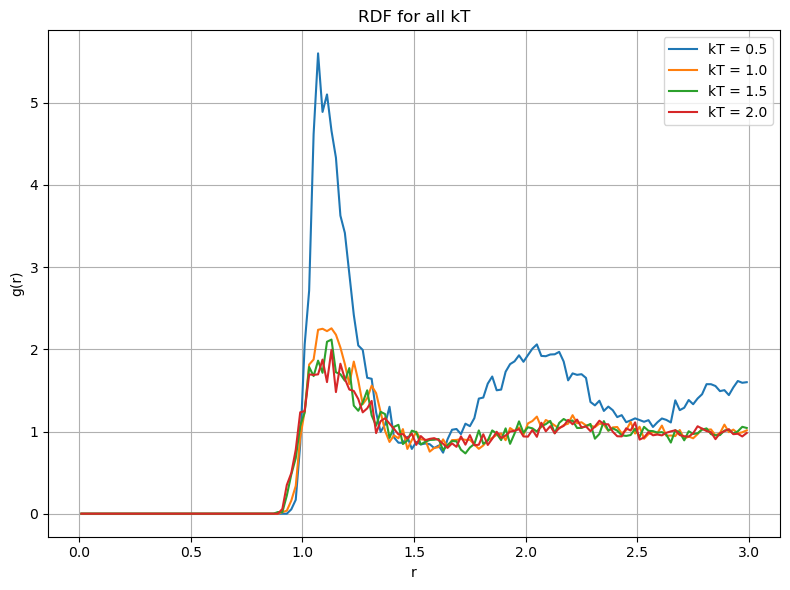

In [99]:
plt.figure(figsize=(8, 6))
for kT in kTs:
    snapshot = snapshots[f"{kT}"] 
    r, g_r = rdf(snapshot, r_max=3.0, bin_width=0.02)
    plt.plot(r, g_r, label=f"kT = {kT}")
plt.xlabel("r")
plt.ylabel("g(r)")
plt.title("RDF for all kT")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

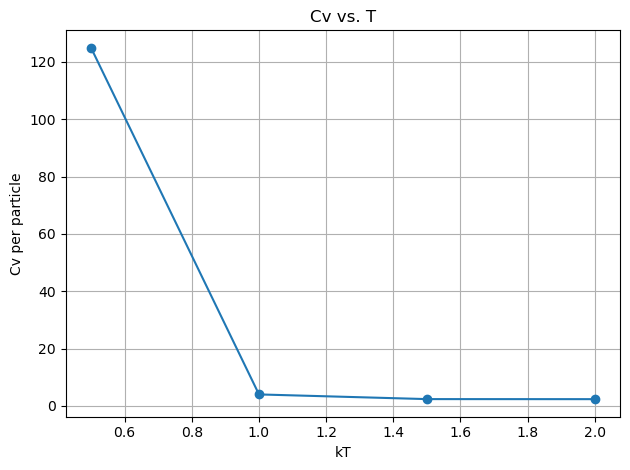

In [100]:
plt.plot(kTs, [heat_capacities[f"{kT}"] for kT in kTs], marker='o')
plt.xlabel("kT")
plt.ylabel("Cv per particle")
plt.title("Cv vs. T")
plt.grid(True)
plt.tight_layout()
plt.show()

Running simulation for kT = 0.5
Running simulation for kT = 1.0
Running simulation for kT = 1.5
Running simulation for kT = 2.0

📊 kT = 0.5
   Decorrelation time ≈ 0.755 time units
   ~66 independent samples out of 10000


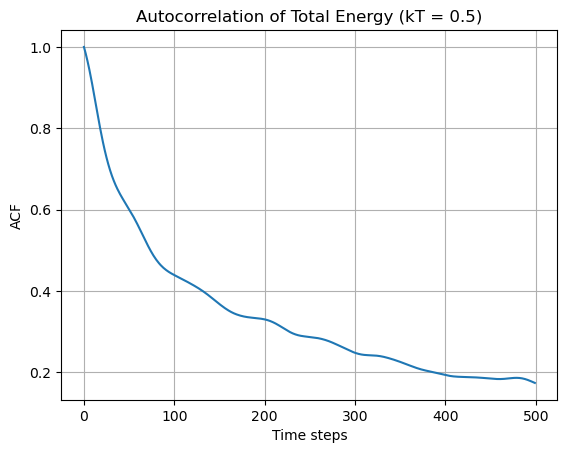


📊 kT = 1.0
   Decorrelation time ≈ 0.065 time units
   ~769 independent samples out of 10000


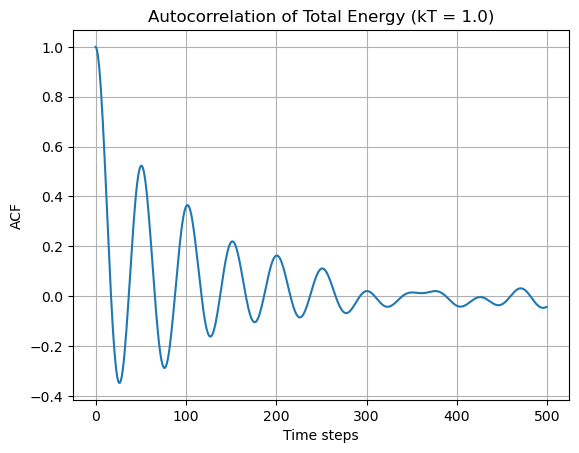


📊 kT = 1.5
   Decorrelation time ≈ 0.050 time units
   ~1000 independent samples out of 10000


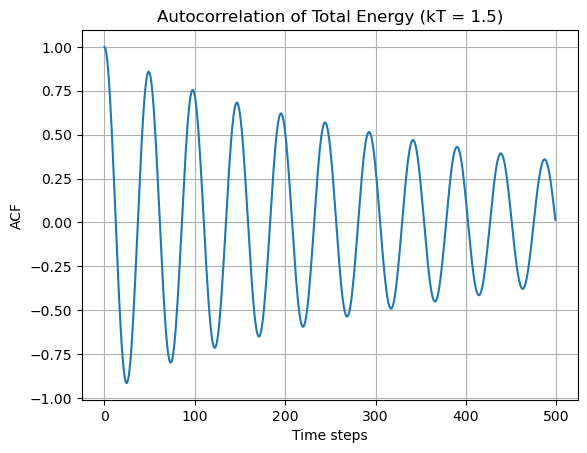


📊 kT = 2.0
   Decorrelation time ≈ 0.050 time units
   ~1000 independent samples out of 10000


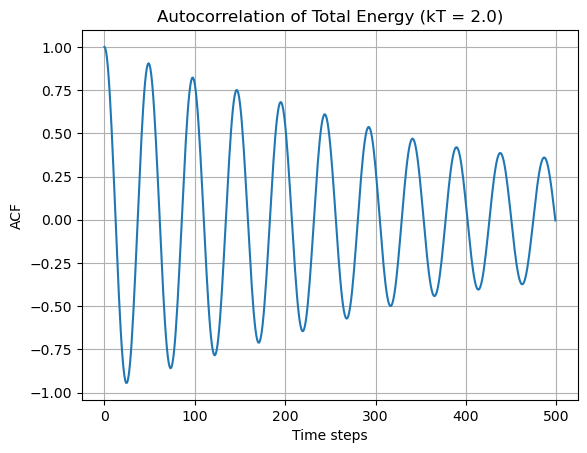

In [29]:
# ---------- Autocorrelation Tools ----------
def autocorr1d(array):
    array = array - np.mean(array)
    fft = np.fft.fft(array, n=2*len(array))
    acf = np.fft.ifft(fft * np.conjugate(fft)).real
    acf = acf[:len(array)] / (np.var(array) * len(array))
    return acf

def find_sample_distance(array):
    acorr = autocorr1d(array)
    threshold = 1 / np.e
    below_thresh = np.where(acorr < threshold)[0]
    return below_thresh[0] if len(below_thresh) > 0 else len(array)

def find_independent_samples(array):
    dist = find_sample_distance(array)
    return len(array) // dist if dist > 0 else 1

# ---------- Analysis ----------
for kT in kTs:
    energies = total_energy[f"{kT}"]
    dist = find_sample_distance(energies)
    n_indep = find_independent_samples(energies)

    print(f"\n📊 kT = {kT}")
    print(f"   Decorrelation time ≈ {dist * dt:.3f} time units")
    print(f"   ~{n_indep} independent samples out of {len(energies)}")

    # Optional plot
    acf = autocorr1d(energies)
    plt.plot(acf[:500])
    plt.title(f"Autocorrelation of Total Energy (kT = {kT})")
    plt.xlabel("Time steps")
    plt.ylabel("ACF")
    plt.grid(True)
    plt.show()